In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm

import causalpy as cp

In [2]:
N = 1000


def inv_logit(x):
    return 1 / (1 + np.exp(-x))


df1 = pd.DataFrame(
    np.random.multivariate_normal([0.5, 1], [[2, 1], [1, 1]], size=N),
    columns=["x1", "x2"],
)
df1["trt"] = np.where(
    -0.5 + 0.25 * df1["x1"] + 0.75 * df1["x2"] + np.random.normal(0, 1, size=N) > 0,
    1,
    0,
)
TREATMENT_EFFECT = 2
df1["outcome"] = (
    4
    + TREATMENT_EFFECT * df1["trt"]
    + df1["x1"]
    + df1["x2"]
    + np.random.normal(0, 1, size=N)
)
df1.head()

,x1,x2,trt,outcome
0,-0.231342,-0.895340,0,3.524464
1,1.870168,1.922164,1,9.622715
2,0.962788,1.296195,0,6.070648
3,-2.094107,-0.034306,0,3.490810
4,-0.253904,-0.364892,0,4.806564


In [3]:
df1["trt"].mean()

0.602

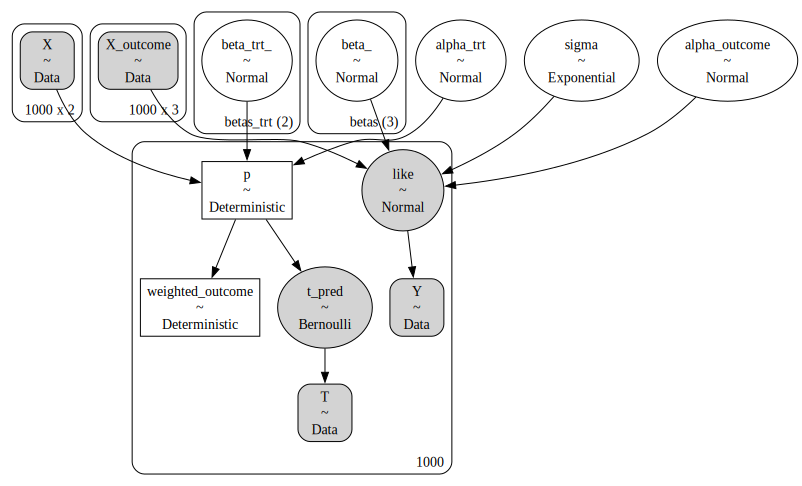

In [ ]:
coords = {
    "betas": ["trt", "x1", "x2"],
    "betas_trt": ["x1", "x2"],
    "obs": range(df1.shape[0]),
}

N = df1.shape[0]
X_trt = df1[["x1", "x2"]].values
X_outcome = df1[["trt", "x1", "x2"]].values
T_data = df1["trt"].values
Y_data = df1["outcome"].values


def make_model(X_trt, X_outcome, T_data, Y_data, coords):
    with pm.Model(coords=coords) as model:
        X_data_trt = pm.Data("X", X_trt)
        X_data_outcome = pm.Data("X_outcome", X_outcome)
        T_data_ = pm.Data("T", T_data)
        Y_data_ = pm.Data("Y", Y_data)

        beta_trt = pm.Normal("beta_trt_", 0, 1, dims="betas_trt")
        beta = pm.Normal("beta_", 0, 1, dims="betas")

        alpha_trt = pm.Normal("alpha_trt", 0, 1)
        mu_trt = alpha_trt + pm.math.dot(X_data_trt, beta_trt)
        p = pm.Deterministic("p", pm.math.invlogit(mu_trt))

        pm.Bernoulli("t_pred", p=p, observed=T_data_)

        alpha_outcome = pm.Normal("alpha_outcome", 0, 1)
        mu_outcome = alpha_outcome + pm.math.dot(X_data_outcome, beta)
        sigma = pm.Exponential("sigma", 1)

        p_inv = pm.math.where(T_data, 1 / p, 1 / (1 - p))

        _ = pm.Deterministic("weighted_outcome", p_inv * Y_data)
        _ = pm.Normal("like", mu_outcome, sigma, observed=Y_data_)

    return model


model = make_model(X_trt, X_outcome, T_data, Y_data, coords)

pm.model_to_graphviz(model)

In [28]:
with model:
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(tune=2000, target_accept=0.95, nuts_sampler="numpyro"))

Sampling: [alpha_outcome, alpha_trt, beta_, beta_trt_, like, sigma, t_pred]


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [29]:
az.summary(idata, var_names=["alpha_trt", "beta_trt_", "alpha_outcome", "beta_"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_trt,-0.937,0.129,-1.184,-0.706,0.002,0.002,2954.0,2773.0,1.0
beta_trt_[x1],0.445,0.083,0.294,0.596,0.002,0.001,3048.0,2863.0,1.0
beta_trt_[x2],1.347,0.133,1.106,1.601,0.003,0.002,2713.0,2664.0,1.0
alpha_outcome,4.039,0.058,3.931,4.152,0.001,0.001,2738.0,2766.0,1.0
beta_[trt],1.883,0.080,1.736,2.033,0.001,0.001,3224.0,3113.0,1.0
beta_[x1],1.044,0.033,0.984,1.108,0.001,0.000,2712.0,2825.0,1.0
beta_[x2],0.996,0.052,0.891,1.089,0.001,0.001,2615.0,2413.0,1.0


In [30]:
df = cp.load_data("nhefs")
df[["age", "race", "trt", "smokeintensity", "smokeyrs", "outcome"]].head()

,age,race,trt,smokeintensity,smokeyrs,outcome
0,42,1,0,30,29,-10.093960
1,36,0,0,20,24,2.604970
2,56,1,0,20,26,9.414486
3,68,1,0,3,53,4.990117
4,40,0,0,20,19,4.989251


In [31]:
coords = {
    "betas": ["trt", "age", "smokeintensity", "smokeyrs", "wt71"],
    "betas_trt": [
        "age",
        "smokeintensity",
        "smokeyrs",
        "wt71",
    ],
    "obs": range(df.shape[0]),
}

N = df.shape[0]
X_trt = df[["age", "smokeintensity", "smokeyrs", "wt71"]]
X_trt = X_trt - X_trt.mean()
X_outcome = df[["trt", "age", "smokeintensity", "smokeyrs", "wt71"]]
X_outcome = X_outcome - X_outcome.mean()
T_data = df["trt"].values
X_outcome["trt"] = T_data
Y_data = df["outcome"].values

new_model = make_model(X_trt, X_outcome, T_data, Y_data, coords)
new_model

       beta_trt_ ~ Normal(0, 1)
           beta_ ~ Normal(0, 1)
       alpha_trt ~ Normal(0, 1)
   alpha_outcome ~ Normal(0, 1)
           sigma ~ Exponential(f())
               p ~ Deterministic(f(beta_trt_, alpha_trt))
weighted_outcome ~ Deterministic(f(beta_trt_, alpha_trt))
          t_pred ~ Bernoulli(p)
            like ~ Normal(f(alpha_outcome, beta_), sigma)

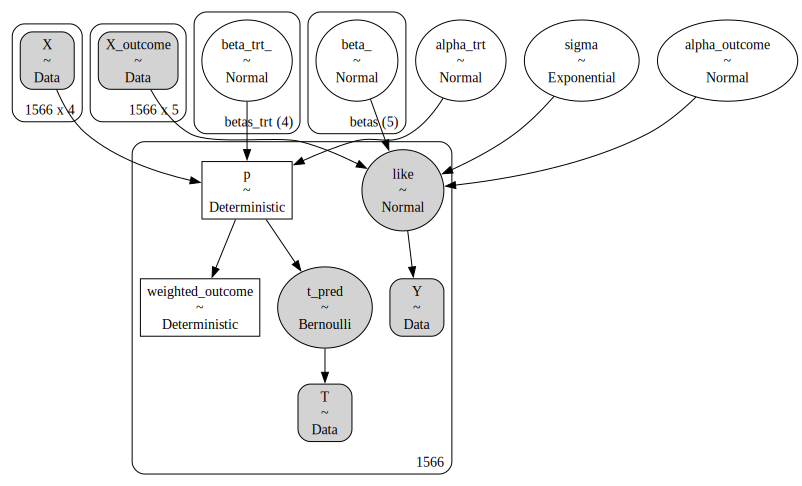

In [32]:
pm.model_to_graphviz(new_model)

In [33]:
with new_model:
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(tune=3000, target_accept=0.99, nuts_sampler="numpyro"))

Sampling: [alpha_outcome, alpha_trt, beta_, beta_trt_, like, sigma, t_pred]


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [34]:
az.summary(idata, var_names=["alpha_trt", "beta_trt_", "alpha_outcome", "beta_"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_trt,-1.098,0.060,-1.210,-0.986,0.001,0.001,6071.0,3167.0,1.0
beta_trt_[age],0.041,0.009,0.024,0.058,0.000,0.000,3210.0,3069.0,1.0
beta_trt_[smokeintensity],-0.018,0.005,-0.028,-0.008,0.000,0.000,5548.0,2777.0,1.0
beta_trt_[smokeyrs],-0.021,0.009,-0.038,-0.004,0.000,0.000,3271.0,3144.0,1.0
beta_trt_[wt71],0.011,0.004,0.003,0.018,0.000,0.000,5397.0,2656.0,1.0
alpha_outcome,1.817,0.214,1.427,2.224,0.003,0.002,3916.0,2925.0,1.0
beta_[trt],2.938,0.399,2.180,3.672,0.006,0.004,3981.0,3207.0,1.0
beta_[age],-0.223,0.032,-0.285,-0.164,0.001,0.000,2984.0,2341.0,1.0
beta_[smokeintensity],0.027,0.017,-0.005,0.058,0.000,0.000,4993.0,3029.0,1.0
beta_[smokeyrs],0.074,0.032,0.016,0.136,0.001,0.000,3079.0,2698.0,1.0


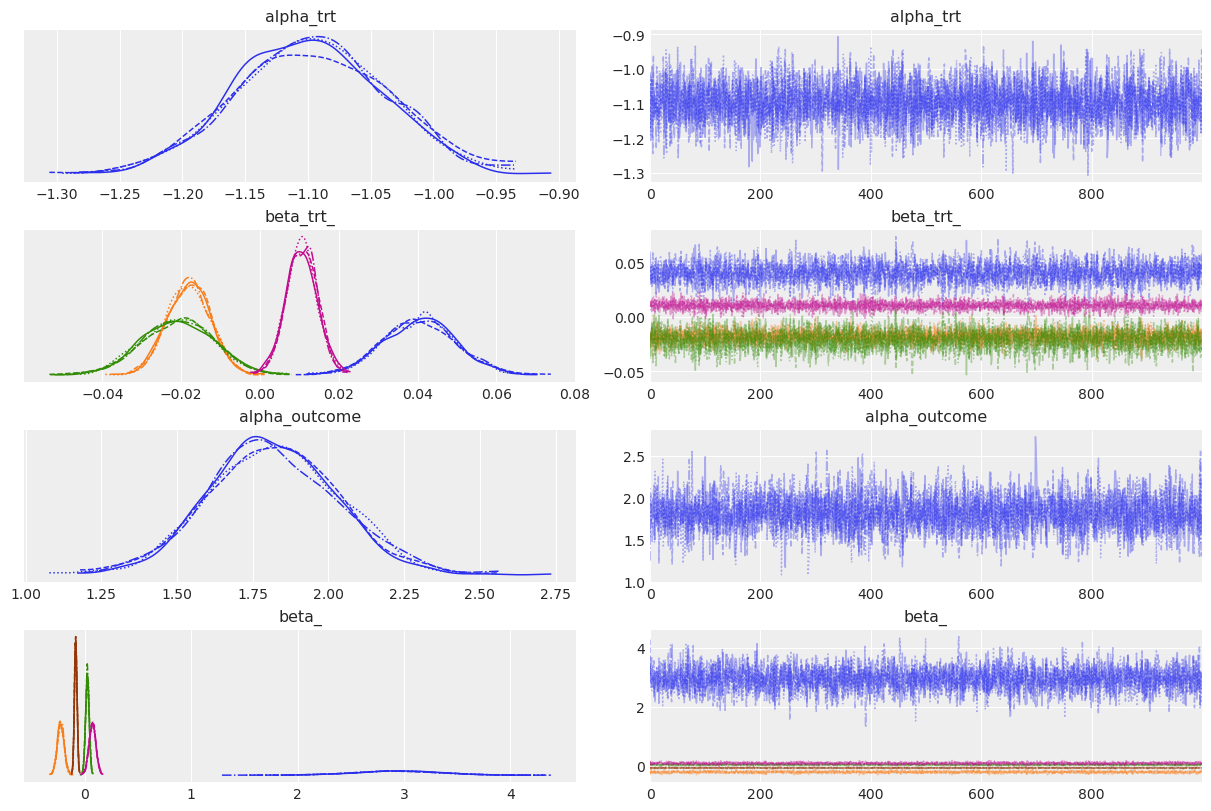

In [35]:
az.plot_trace(idata, var_names=["alpha_trt", "beta_trt_", "alpha_outcome", "beta_"]);